In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
from scipy import stats
import seaborn as sns
import warnings
import time

from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.utils import resample
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
df = pd.read_csv(r"C:\MIDS\ADS_505_Applied_Data_Science_for_Business\ADS-505_Final_Project_Team_4\data\german_credit_data.csv", index_col=0)
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


### Feature Creation

In [3]:
# Create categorical feature for age
interval = (18, 25, 35, 60, 120)
# (18, 25) represents the interval for "Students" (ages 18 to 25).
# (25, 35) represents the interval for "Young" adults (ages 26 to 35).
# (35, 60) represents the interval for "Adults" (ages 36 to 60).
# (60, 120) represents the interval for "Seniors" (ages 61 to 120).
cats = ['Student', 'Young Adult', 'Adult', 'Senior']
df["Age_cat"] = pd.cut(df.Age, interval, labels=cats)

### Summary Statistics

In [4]:
def analyze_data(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name', 'dtypes']]
    summary['Missing'] = df.isnull().sum().values
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2), 2)

        if df[name].dtype in ['float64', 'int64']:
            summary.loc[summary['Name'] == name, 'Skewness'] = round(stats.skew(df[name]), 2)
            summary.loc[summary['Name'] == name, 'Kurtosis'] = round(stats.kurtosis(df[name]), 2)
            summary.loc[summary['Name'] == name, 'Min'] = df[name].min()
            summary.loc[summary['Name'] == name, 'Mean'] = df[name].mean()
            summary.loc[summary['Name'] == name, 'Median'] = df[name].median()
            summary.loc[summary['Name'] == name, 'Max'] = df[name].max()
            summary.loc[summary['Name'] == name, 'Std'] = df[name].std()

            # Outlier detection using IQR
            Q1 = df[name].quantile(0.25)
            Q3 = df[name].quantile(0.75)
            IQR = Q3 - Q1
            outliers = df[(df[name] < Q1 - 1.5 * IQR) | (df[name] > Q3 + 1.5 * IQR)]
            summary.loc[summary['Name'] == name, 'Outliers'] = len(outliers)

    return summary

# Analyze the dataset and store the summary
summary = analyze_data(df)
summary

Dataset Shape: (1000, 11)


,Name,dtypes,Missing,Uniques,First Value,Entropy,Skewness,Kurtosis,Min,Mean,Median,Max,Std,Outliers
0,Age,int64,0,53,67,5.27,1.02,0.59,19.0,35.546,33.0,75.0,11.375469,23.0
1,Sex,object,0,2,male,0.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Job,int64,0,4,2,1.41,-0.37,0.49,0.0,1.904,2.0,3.0,0.653614,370.0
3,Housing,object,0,3,own,1.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Saving accounts,object,183,4,NaN,1.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Checking account,object,394,3,little,1.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Credit amount,int64,0,921,1169,9.80,1.95,4.27,250.0,3271.258,2319.5,18424.0,2822.736876,72.0
7,Duration,int64,0,33,6,3.76,1.09,0.91,4.0,20.903,18.0,72.0,12.058814,70.0
8,Purpose,object,0,8,radio/TV,2.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Risk,object,0,2,good,0.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Target Variable Distribution 

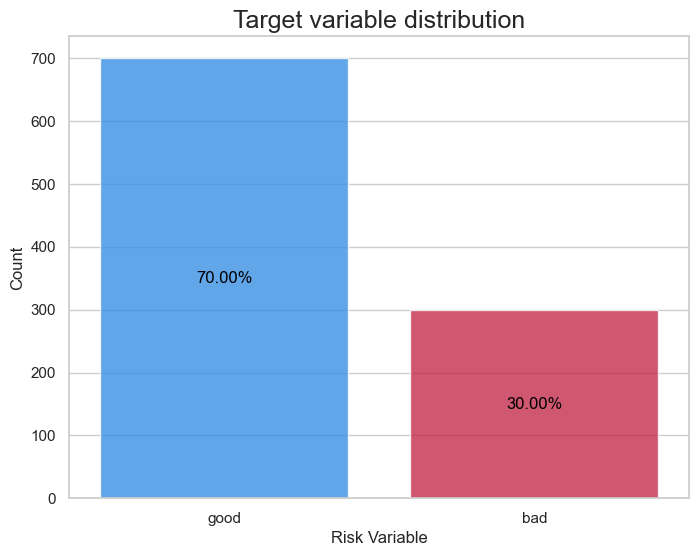

In [5]:
# Calculate the counts for 'good' and 'bad' credit
counts = df['Risk'].value_counts()

# Calculate the percentages
total_count = counts.sum()
percentages = (counts / total_count) * 100

# Create a bar chart with percentages in the center of each bar using Seaborn
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")
ax = sns.barplot(x=counts.index, y=counts.values, palette=['dodgerblue', 'crimson'], alpha=0.8)
plt.xlabel('Risk Variable')
plt.ylabel('Count')
plt.title('Target variable distribution', fontsize=18)

# Add percentages at the center of each bar
for bar, percentage in zip(ax.patches, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, f'{percentage:.2f}%', 
             ha='center', va='center', fontsize=12, color='black')

# Save the plot to the "plots" folder
plots_folder = 'plots'
if not os.path.exists(plots_folder):
    os.makedirs(plots_folder)
plot_filename = os.path.join(plots_folder, 'target_variable_distribution.png')
plt.savefig(plot_filename)

plt.show()

#### Distribution of Numerical Features vs Target

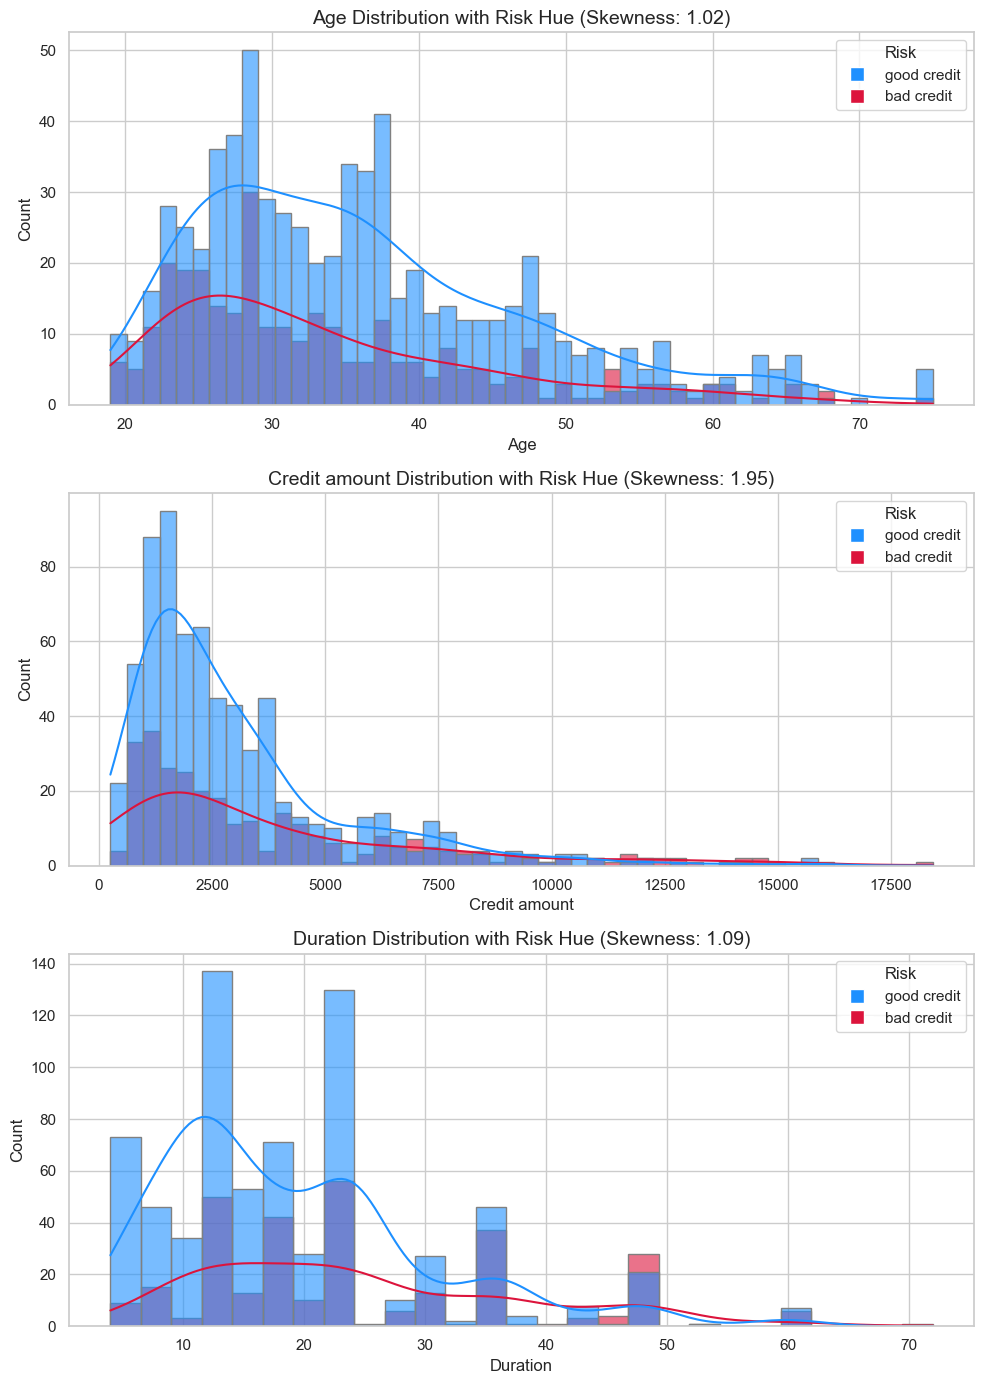

In [6]:
# Create a 3x1 grid of histograms with different bin counts
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 1, figsize=(10, 14))

# Columns to plot and their corresponding bin counts
columns_to_plot = ['Age', 'Credit amount', 'Duration']
bin_counts = [50, 50, 27]  # Adjust the bin counts as needed

# Loop through columns and create histograms with specified bin counts
for i, (column, bins) in enumerate(zip(columns_to_plot, bin_counts)):
    ax = axes[i]
    
    # Calculate skewness
    skewness = df[column].skew()
    
    sns.histplot(data=df, x=column, hue='Risk', alpha=0.6, element='bars', bins=bins, 
                 palette={'good': 'dodgerblue', 'bad': 'crimson'}, edgecolor='grey', kde=True, legend=True, ax=ax)
    ax.set_xlabel(column)
    ax.set_ylabel('Count')
    
    # Add skewness to the title
    ax.set_title(f'{column} Distribution with Risk Hue (Skewness: {skewness:.2f})', fontsize=14)
    sns.set(style="whitegrid")
    legend_labels = ['good credit', 'bad credit']
    legend_colors = ['dodgerblue', 'crimson']
    legend_handles = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color, markersize=10, label=label) for color, label in zip(legend_colors, legend_labels)]
    ax.legend(handles=legend_handles, title='Risk')

# Adjust spacing between subplots
plt.tight_layout()

# Save the plot to the "plots" folder
plots_folder = 'plots'
if not os.path.exists(plots_folder):
    os.makedirs(plots_folder)
plot_filename = os.path.join(plots_folder, 'age_creditamount_duration_distributions.png')
plt.savefig(plot_filename)

plt.show()

#### Distribution of Categorical Features vs Target

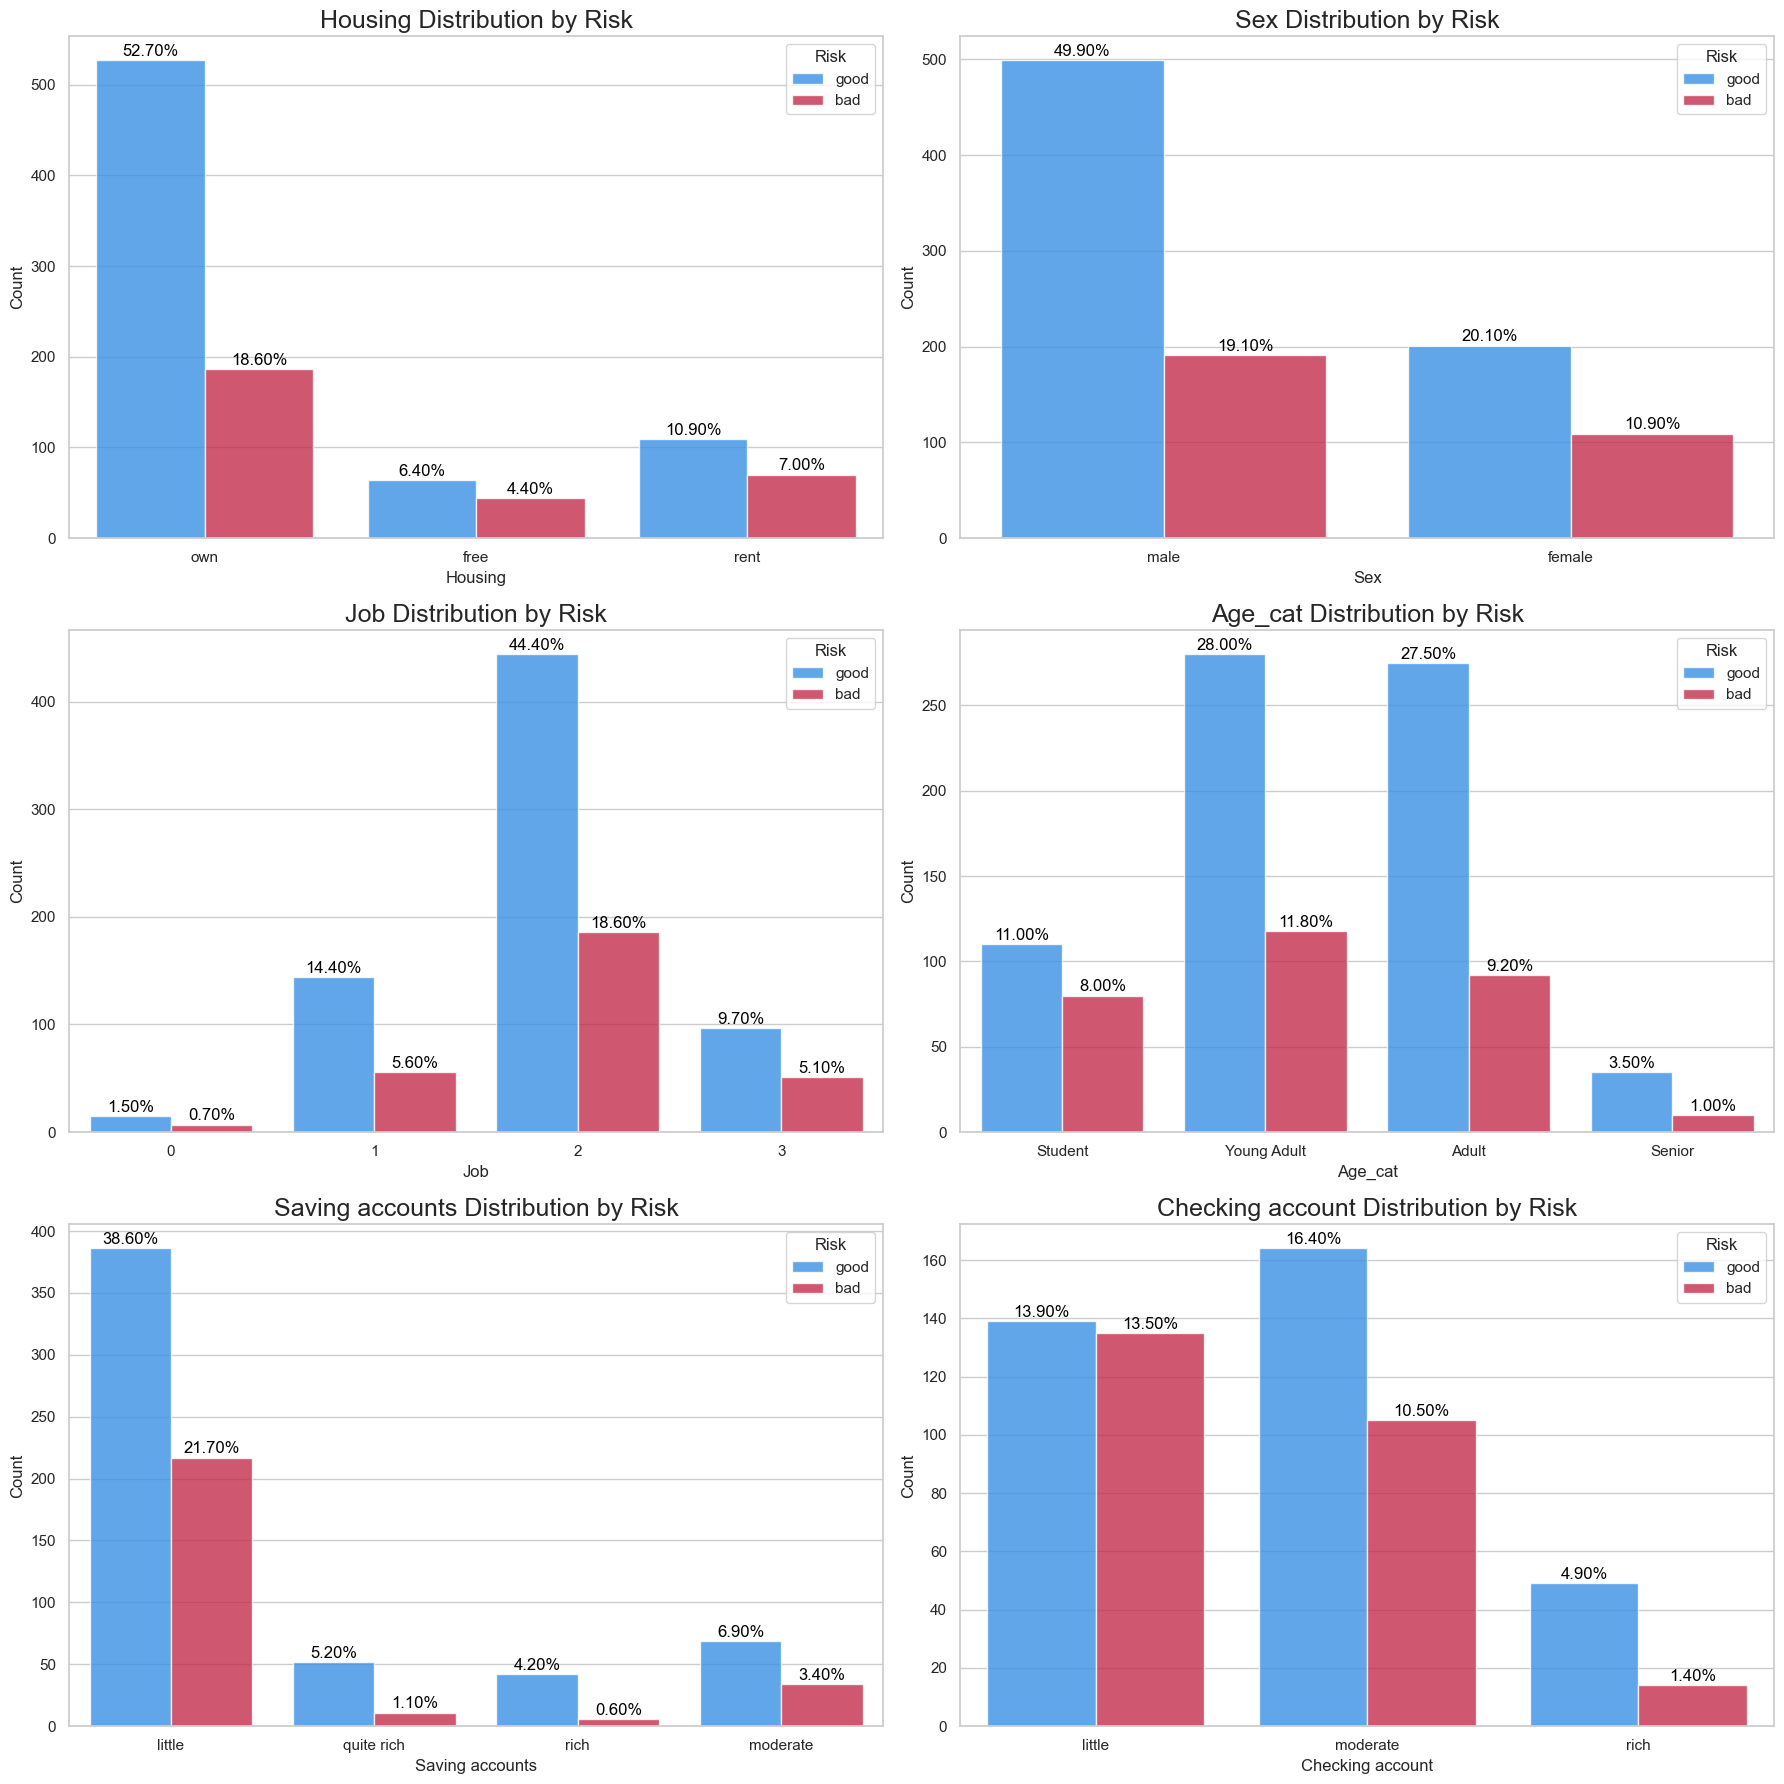

In [7]:
# Create a 3x2 grid of count plots
fig, axes = plt.subplots(3, 2, figsize=(18, 18))
# Columns to plot
columns_to_plot = ['Housing', 'Sex', 'Job', 'Age_cat', 'Saving accounts', 'Checking account']

# Loop through columns and create count plots
for i, column in enumerate(columns_to_plot):
    row = i // 2
    col = i % 2
    ax = sns.countplot(data=df, x=column, hue='Risk', alpha=0.8, palette={'good': 'dodgerblue', 'bad': 'crimson'}, ax=axes[row, col])
    ax.set_xlabel(column)
    ax.set_ylabel('Count')
    ax.set_title(f'{column} Distribution by Risk', fontsize=18)  
    
    # Add percentages on top of the bars
    for bar in ax.patches:
        height = bar.get_height()
        ax.annotate(f'{height / len(df) * 100:.2f}%', 
                    xy=(bar.get_x() + bar.get_width() / 2, height), 
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords='offset points',
                    ha='center', fontsize=12, color='black')

# Adjust spacing between subplots
plt.tight_layout()
plt.legend(title='Risk', loc='upper right')

# Save the plot to the "plots" folder
plots_folder = 'plots'
if not os.path.exists(plots_folder):
    os.makedirs(plots_folder)
plot_filename = os.path.join(plots_folder, 'categorical_var_vs_risk.png')
plt.savefig(plot_filename)

plt.show()

### Data Preprocessing & Feature Engineering/Transformation
#### Standarization of the numerical variables and one hot encoding of the categorical variables
#### Re-sampling due to the class imbalance

In [12]:
# Define categorical columns
categorical_columns = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Age_cat']
df_cat = df[categorical_columns]

# Define numerical columns
numerical_columns = ['Age', 'Job', 'Credit amount', 'Duration']
df_num = df[numerical_columns]

# # One-hot encode the categorical columns
df_encoded = pd.get_dummies(df_cat)

# Scale the numerical columns
scaler = StandardScaler()
df_num_scaled = scaler.fit_transform(df_num)
df_num_scaled = pd.DataFrame(df_num_scaled, columns=numerical_columns)
df_num_scaled

# Map 'Risk' to binary values
risk_mapping = {'bad': 0, 'good': 1}
df['Risk_num'] = df['Risk'].map(risk_mapping)

# Merge the scaled numerical columns with the one-hot encoded categorical columns
df_processed = pd.concat([df_encoded, df_num_scaled, df["Risk_num"]], axis=1)

# Oversample the minority class using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(df_encoded, df['Risk_num'])

# Create a DataFrame from the resampled data
df_resampled = pd.concat([X_resampled, df_num_scaled, y_resampled], axis=1)
df_resampled['Risk_num'].value_counts()  # Check the class distribution

1    700
0    700
Name: Risk_num, dtype: int64

### Assess Feature Integrity, multicollinearity and p-values

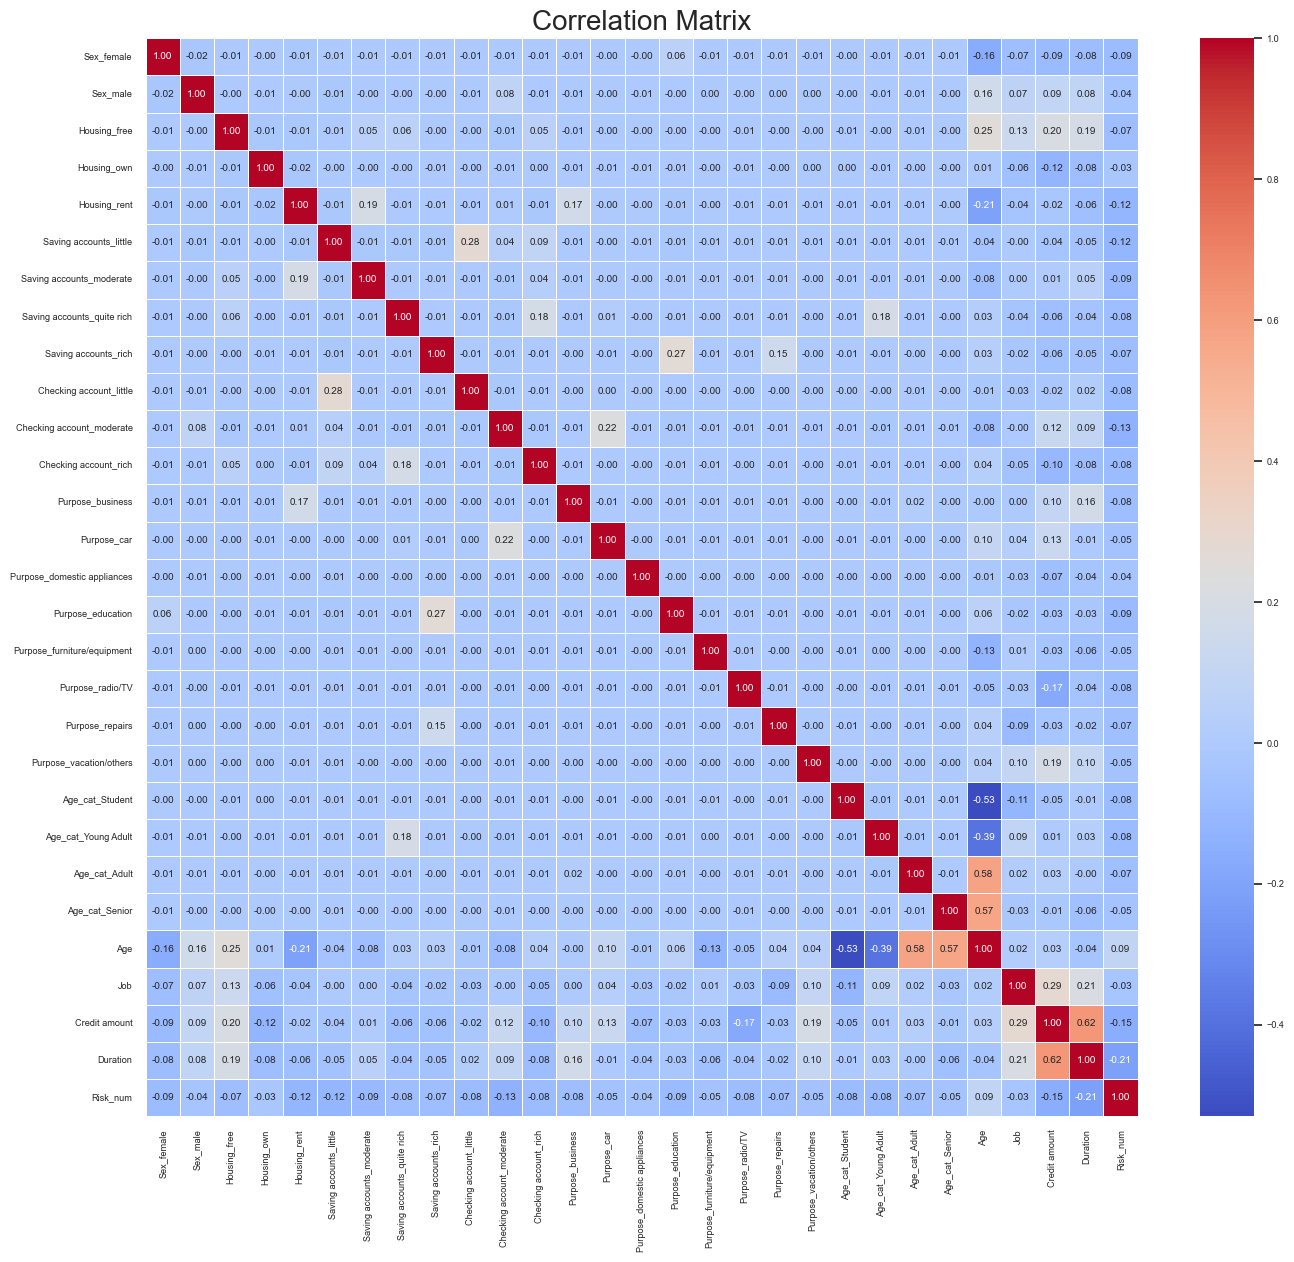

In [13]:
# Calculate the correlation matrix
correlation_matrix = df_resampled.corr()

# Set up the figure and axis for the heatmap
plt.figure(figsize=(16, 14))
sns.set(font_scale=0.6)  # Adjust the font scale if needed

# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix', fontsize=20)

# Save the plot to the "plots" folder
plots_folder = 'plots'
if not os.path.exists(plots_folder):
    os.makedirs(plots_folder)
plot_filename = os.path.join(plots_folder, 'correlation_matrix_heatmap.png')
plt.savefig(plot_filename)

plt.show()

### Machine Learning Classifiers 

Class Distribution:
1    700
0    300
Name: Risk_num, dtype: int64


Classifiers Progress:   0%|                                          | 0/11 [00:00<?, ?it/s]

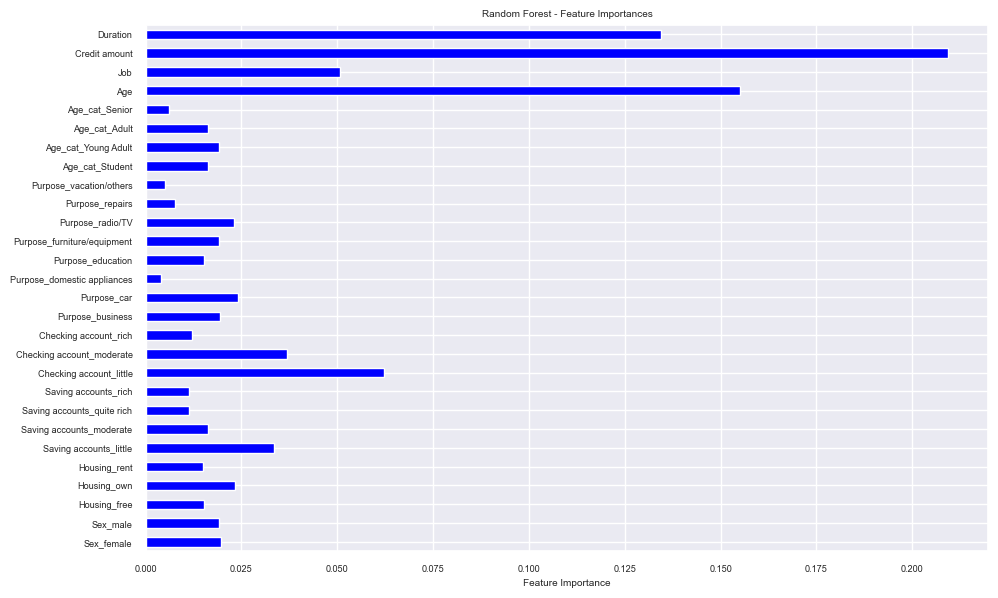

Classifiers Progress:   9%|███                               | 1/11 [00:01<00:10,  1.02s/it]

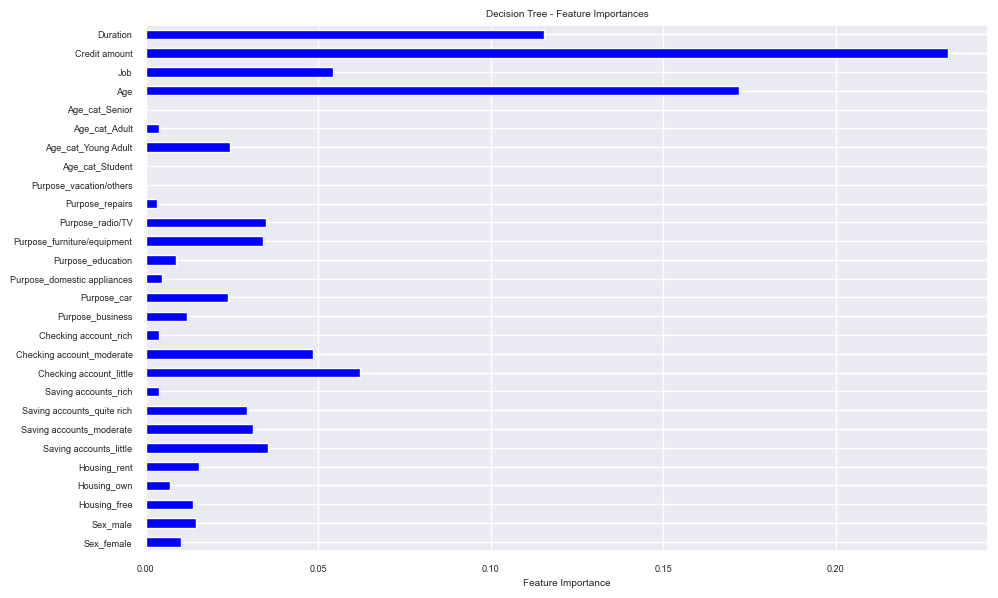

Classifiers Progress:  18%|██████▏                           | 2/11 [00:01<00:07,  1.24it/s]

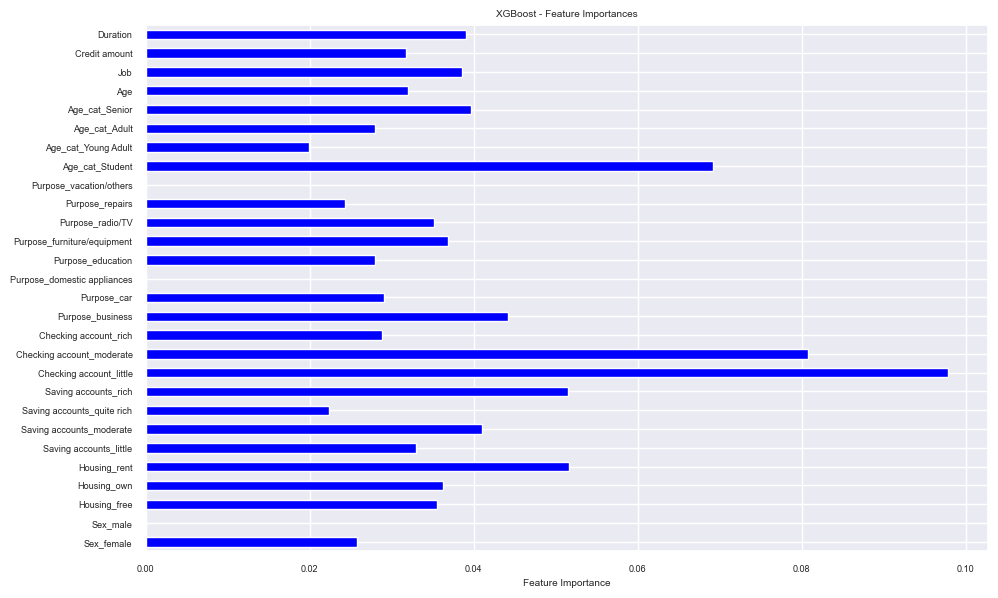

Classifiers Progress:  55%|██████████████████▌               | 6/11 [00:05<00:03,  1.42it/s]

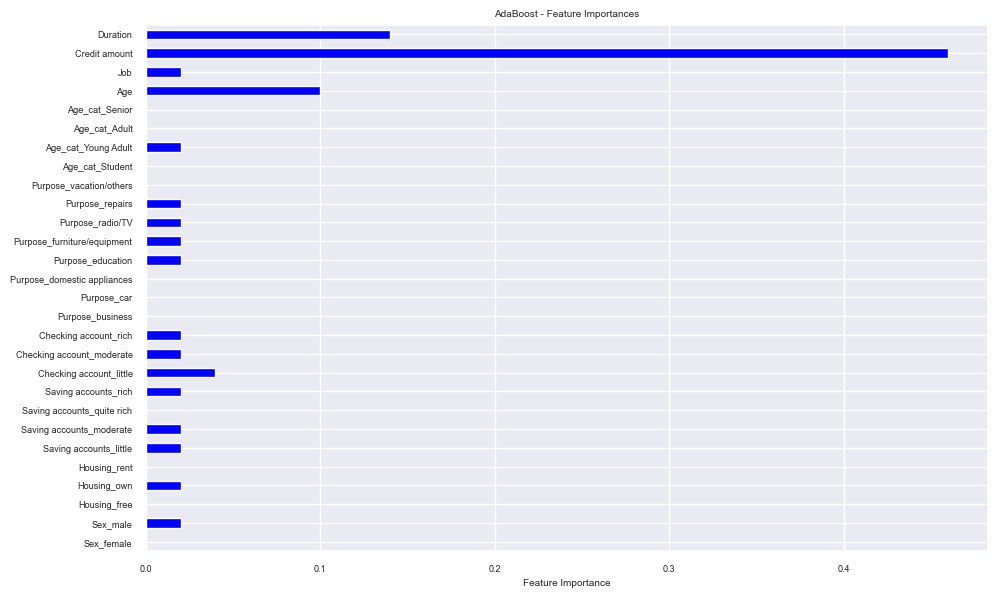

Classifiers Progress: 100%|█████████████████████████████████| 11/11 [00:06<00:00,  1.80it/s]

Random Forest - Evaluation Metrics:
Accuracy: 0.715
Precision: 0.7592592592592593
Sensitivity/Recall: 0.8723404255319149
Specificity: 0.3389830508474576
ROC AUC: 0.7322394518571943
Elapsed Time: 0.2122 seconds

Decision Tree - Evaluation Metrics:
Accuracy: 0.68
Precision: 0.781021897810219
Sensitivity/Recall: 0.7588652482269503
Specificity: 0.4915254237288136
ROC AUC: 0.6251953359778819
Elapsed Time: 1.0306 seconds

XGBoost - Evaluation Metrics:
Accuracy: 0.745
Precision: 0.7960526315789473
Sensitivity/Recall: 0.8581560283687943
Specificity: 0.4745762711864407
ROC AUC: 0.7666786873422285
Elapsed Time: 2.7885 seconds

Neural Network - Evaluation Metrics:
Accuracy: 0.735
Precision: 0.7972972972972973
Sensitivity/Recall: 0.8368794326241135
Specificity: 0.4915254237288136
ROC AUC: 0.7380694795047481
Elapsed Time: 4.9850 seconds

Logistic Regression - Evaluation Metrics:
Accuracy: 0.76
Precision: 0.7818181818181819
Sensitivity/Recall: 0.9148936170212766
Specificity: 0.3898305084745763
ROC A

In [15]:
# Declare target variable and predictor variables
X = df_processed.drop(columns=['Risk_num'])
y = df_processed['Risk_num']

# Check class balance
class_counts = y.value_counts()
print("Class Distribution:")
print(class_counts)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize classifiers
classifiers = {
    'Random Forest': (RandomForestClassifier(random_state=42), {}),
    'Decision Tree': (DecisionTreeClassifier(random_state=42), {}),
    'XGBoost': (XGBClassifier(random_state=42), {}),
    'Neural Network': (MLPClassifier(hidden_layer_sizes=(100,), random_state=42), {}),
    'Logistic Regression': (LogisticRegression(random_state=42), {}),
    'K-Nearest Neighbors': (KNeighborsClassifier(), {}),
    'AdaBoost': (AdaBoostClassifier(random_state=42), {}),
    'Naive Bayes': (GaussianNB(), {}),
    'Bagging Classifier': (BaggingClassifier(base_estimator=DecisionTreeClassifier(), random_state=42), {}),
    'Quadratic Discriminant Analysis': (QuadraticDiscriminantAnalysis(), {}),
    'Linear Discriminant Analysis': (LinearDiscriminantAnalysis(), {}),
}

# Initialize dictionaries to store results and ROC AUC scores
results = {}
roc_auc_scores = {}

# Define start_time before the loop
start_time = time.time()

for name, (classifier, _) in tqdm(classifiers.items(), desc='Classifiers Progress'):
    # Train and evaluate the classifier as before
    classifier.fit(X_train, y_train)
    end_time = time.time()
    elapsed_time = end_time - start_time

    # Obtain predicted probabilities for the positive class
    y_pred_probs = classifier.predict_proba(X_test)[:, 1]
    
    threshold = 0.5  # You can adjust this threshold as needed

    # Adjust the threshold to convert probabilities to binary predictions
    y_pred = (y_pred_probs > threshold).astype(int)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)
    roc_auc = roc_auc_score(y_test, y_pred_probs)

    feature_importances = None
    if hasattr(classifier, 'feature_importances_'):
        feature_importances = pd.Series(classifier.feature_importances_, index=X.columns)
        
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Sensitivity/Recall': recall,
        'Specificity': specificity,
        'ROC AUC': roc_auc,
        'Elapsed Time': elapsed_time,
        'Feature Importances': feature_importances,
        'y_pred_probs': y_pred_probs  # Store the predicted probabilities
    }
    
    # Store the ROC AUC score for later plotting
    roc_auc_scores[name] = roc_auc

    # Plot feature importances and save to the "plots" folder
    if feature_importances is not None:
        plt.figure(figsize=(10, 6))
        feature_importances.plot(kind='barh', color="blue")  # Use the same color for all plots
        plt.xlabel('Feature Importance')
        plt.title(f'{name} - Feature Importances')
        plt.tight_layout()
        
        # Save the plot to the "plots" folder
        plots_folder = 'plots'
        if not os.path.exists(plots_folder):
            os.makedirs(plots_folder)
        plot_filename = os.path.join(plots_folder, f'{name}_feature_importance_plot.png')
        plt.savefig(plot_filename)
        plt.show()

# Print results without numerical values
for name, metrics in results.items():
    print(f"{name} - Evaluation Metrics:")
    for metric, value in metrics.items():
        if metric == 'Feature Importances' or metric == 'y_pred_probs':
            continue  # Skip printing feature importances and y_pred_probs
        if metric == 'Elapsed Time':
            print(f"{metric}: {value:.4f} seconds")
        else:
            print(f"{metric}: {value}")
    print()

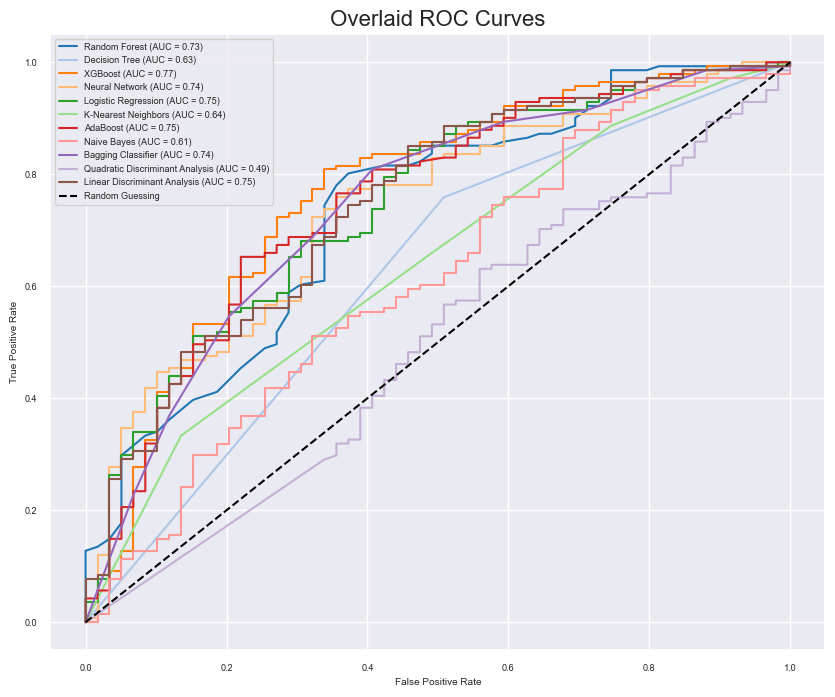

In [16]:
# Initialize an empty figure
plt.figure(figsize=(10, 8))

# Choose the 'tab20' colormap
cmap = cm.get_cmap('tab20')

# Plot the ROC curves for each model
for i, name in enumerate(roc_auc_scores.keys()):
    fpr, tpr, _ = roc_curve(y_test, results[name]['y_pred_probs'])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_scores[name]:.2f})', color=cmap(i))

# Plot the random guessing line
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random Guessing')

# Set plot labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Overlaid ROC Curves', fontsize=16)
plt.legend()

# Save the plot to the "plots" folder
plots_folder = 'plots'
if not os.path.exists(plots_folder):
    os.makedirs(plots_folder)
plot_filename = os.path.join(plots_folder, 'overlaid_roc_curve.png')
plt.savefig(plot_filename)

# Show the plot
plt.show()

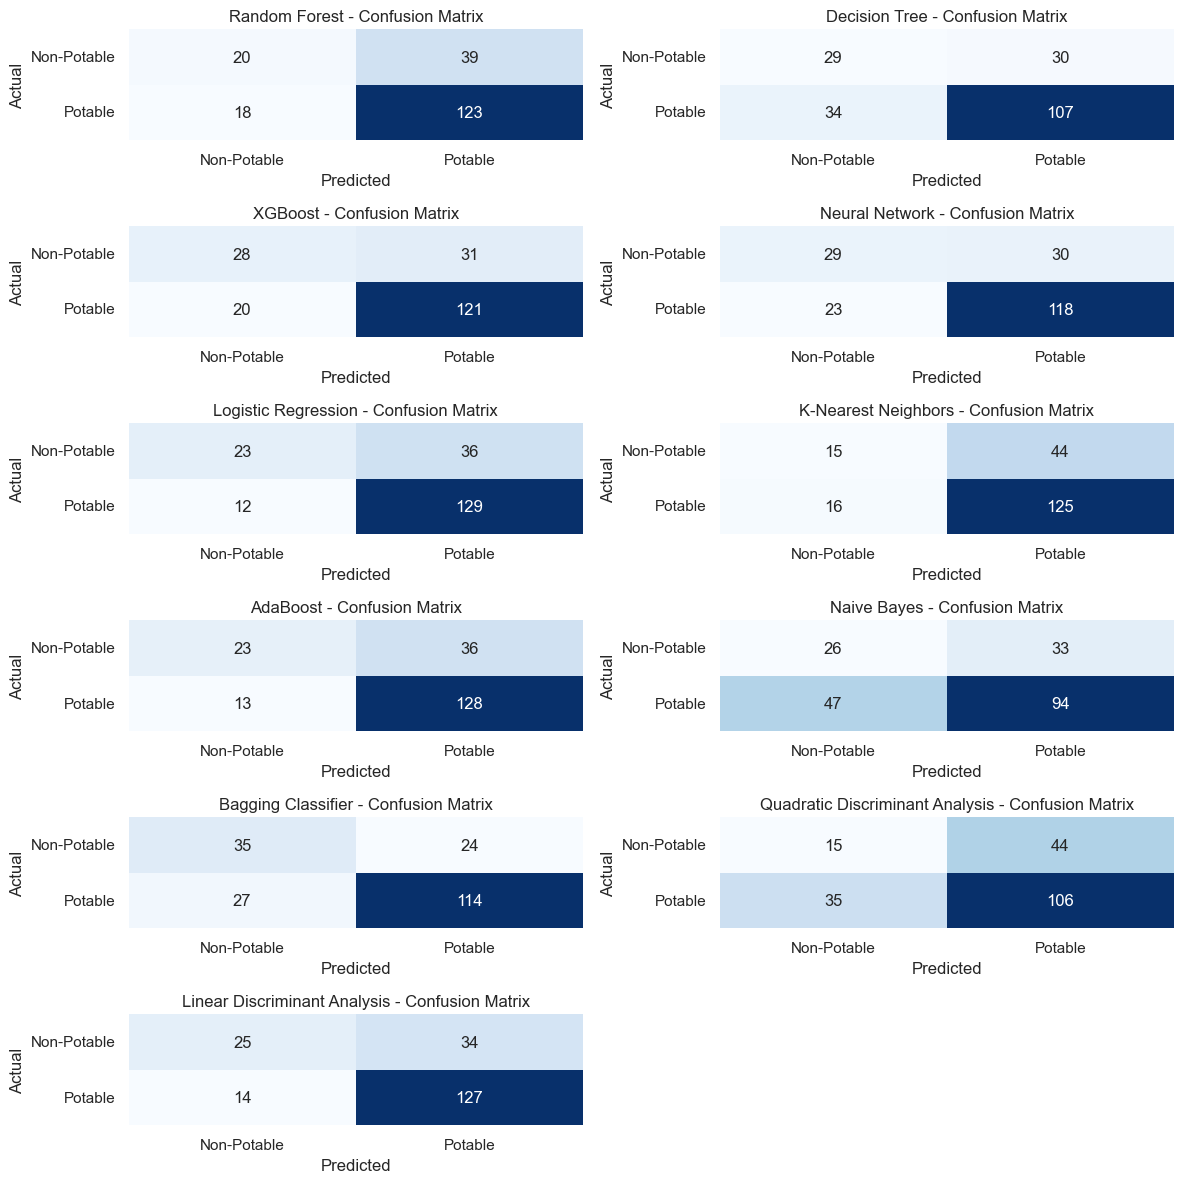

In [17]:
# Define the path to the plots folder
plots_folder = 'plots'

# Create the plots folder if it doesn't exist
if not os.path.exists(plots_folder):
    os.makedirs(plots_folder)

# Create a grid of confusion matrices
plt.figure(figsize=(12, 12))
grid_rows = len(classifiers) // 2 + len(classifiers) % 2
grid_cols = 2
sns.set(style="whitegrid")

for idx, (name, _) in enumerate(classifiers.items(), start=1):
    plt.subplot(grid_rows, grid_cols, idx)
    conf_matrix = confusion_matrix(y_test, results[name]['y_pred_probs'] > threshold)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Non-Potable', 'Potable'], yticklabels=['Non-Potable', 'Potable'])
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()

# Save the combined plot
combined_plot_filename = os.path.join(plots_folder, 'confusion_matrix_combined.png')
plt.savefig(combined_plot_filename)
plt.show()

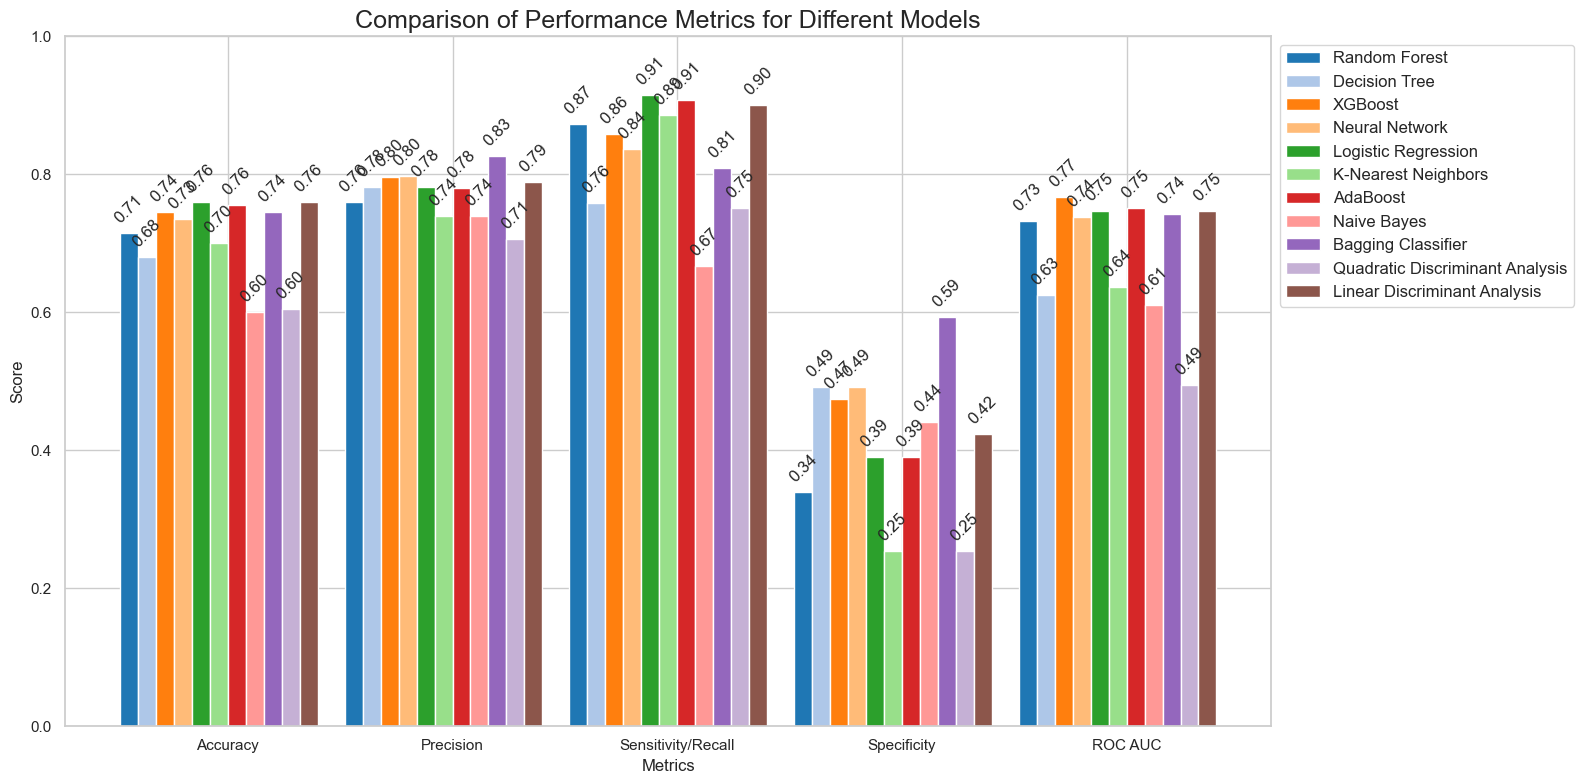

In [18]:
# List of metrics to include in the bar plot
metrics_to_plot = ['Accuracy', 'Precision', 'Sensitivity/Recall', 'Specificity', 'ROC AUC']

# Initialize a figure and axis
plt.figure(figsize=(16, 8))
ax = plt.gca()

# Define the width of each group of bars
bar_width = 0.08

# Create an array of x positions for each set of bars
x_positions = np.arange(len(metrics_to_plot))

# Choose the 'tab20' colormap
cmap = cm.get_cmap('tab20')

# Iterate through each classifier and plot the metrics
for i, (name, metrics) in enumerate(results.items()):
    values = [metrics[metric] for metric in metrics_to_plot]
    x = x_positions + i * bar_width
    
    bars = ax.bar(x, values, width=bar_width, align='center', label=name, color=cmap(i))
    
    # Add metric values on top of each bar with rotation
    for bar, value in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{value:.2f}',
                ha='center', va='bottom', rotation=45) 

# Configure plot settings
ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Comparison of Performance Metrics for Different Models', fontsize=18)
ax.set_xticks(x_positions + bar_width * len(results) / 2)
ax.set_xticklabels(metrics_to_plot)
ax.legend(bbox_to_anchor=(1, 1), loc='upper left', prop={'size': 12})  
ax.set_ylim(0, 1)

# Save the plot to the "plots" folder
plots_folder = 'plots'
if not os.path.exists(plots_folder):
    os.makedirs(plots_folder)
plot_filename = os.path.join(plots_folder, 'performance_metrics_comparison.png')
plt.savefig(plot_filename)

# Show the plot
plt.tight_layout()
plt.show()